<a href="https://colab.research.google.com/github/sharmita01/Coursework_projects/blob/main/Variational_autoencoder_SDey.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VAE Exercise


 ### GENERAL INFORMATION
 * Deep Learning – Winter term 2020/21
 * Instructor: Alexander Ecker
 * Tutors: Max Burg, Laura Pede
 * Teaching assistants: Clara Holzhüter, Pronaya Prosun Das
 * Due date: **Tue, Jan 26, 14:00**

In this exercise a variational autoencoder (VAE) shall be implemented and trained on the fashion MNIST dataset. VAEs are an example of generative deep learning and can be used to synthesize data - images in this case - which shall also be demonstrated in this exercise!

### IMPORTANT SUBMISSION INSTRUCTIONS

- When you're done, download the notebook and rename it to \<surname1\>_\<surname2\>_\<surname3\>.ipynb
- Only submit the ipynb file, no other file is required
- Submit only once
- The deadline is strict
- You are required to present your solution in the tutorial; submission of the notebook alone is not sufficient

### TASKS
* TASK 1: Implement a VAE
* TASK 2: Train the model and plot train+test set loss over training in the same plot
* TASK 3: Determine optimal dimensionality of latent space
* TASK 4: Plot some latent traversals
* TASK 5: Visualize class labels in latent space


## Setup and requirements

### Imports

In [ ]:
from __future__ import print_function
import pathlib

import matplotlib.pyplot as plt

import torch
import torch.utils.data

from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
import torchvision.utils

import numpy as np

!nvcc --version
!python --version
print(torch.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243
Python 3.6.9
1.7.0+cu101


### Basic setup

Define various global parameters used throughout the notebook!

In [ ]:
# Try to use GPU if available
use_cuda = True

# Path for data
data_dir = pathlib.Path('data/')

# Batch size
batch_size = 128

# Image size (same size in both dimensions)
image_size = 28

# Dimension of the latent space
latent_space_dim = 10

# Number of epochs to train
epochs = 5

# How many batches to skip before logging training status
log_interval = 100

# Exponential averaging factor for loss graphs
exp_average_factor = 0.90

# Channels in the convolutional layers
capacity = 32

# Learning rate for the optimizer
learning_rate = 1e-3

# Define size / zoom level of plots
plot_zoom = 2
plot_w, plot_h = plt.figure().get_size_inches()
plot_w = plot_w * plot_zoom; plot_h = plot_h * plot_zoom;

<Figure size 432x288 with 0 Axes>

Test if a GPU (CUDA) is available in the environment and use it if it is. Otherwise use the CPU.

In [ ]:
if use_cuda and not torch.cuda.is_available():
    print("Error: cuda requested but not available, will use cpu instead!")
    device = torch.device('cpu')
elif not use_cuda:
    print("Info: will use cpu!")
    device = torch.device('cpu')
else:
    print("Info: cuda requested and available, will use gpu!")
    device = torch.device('cuda')


Info: cuda requested and available, will use gpu!


## Get and preprocess the data


We will use the FashionMNIST data set from Zalando (https://github.com/zalandoresearch/fashion-mnist) for our experiments.  
From the quoted github-repo: "Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. We intend Fashion-MNIST to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits."


### Load the data for training and testing

The FashionMNIST dataset is already included in the torchvision datasets with the approriate training and test splits. Run the cell below to use it in this notebook!

In [ ]:
train_dataset = datasets.FashionMNIST(data_dir, train=True, download=True, transform=transforms.ToTensor())
test_dataset  = datasets.FashionMNIST(data_dir, train=False, transform=transforms.ToTensor())

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw
Processing...


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


For comparison, you can also use the well known MNIST dataset, which is also already included in the torchvision datasets with the approriate training and test splits. Just run the cell included in the appendix instead if you want to use it in this notebook!

Define data loaders for the training and test sets which return batches of samples.

In [ ]:
# Define the data loaders
train_loader  = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader   = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Save data set sizes for later
train_size    = len(train_dataset)
test_size     = len(test_dataset)
train_batches = len(train_loader)
test_batches  = len(test_loader)

### Plot the data

To get an impression of the dataset plot some random exemplary pictures.

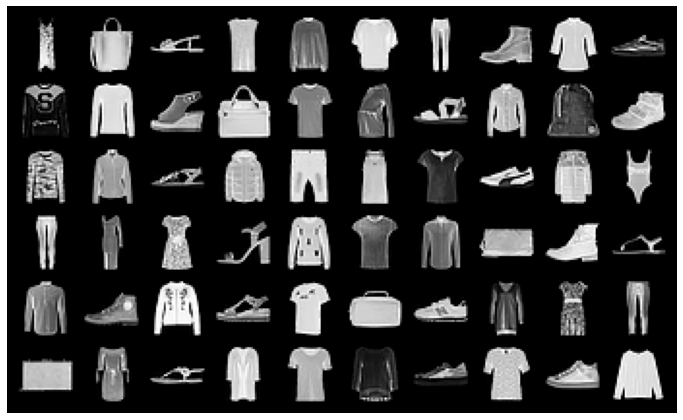

In [ ]:
images_columns = 10
images_rows    = 6

def show_grid(images_tensor, images_columns, images_rows):
    image = torchvision.utils.make_grid(images_tensor, images_columns, images_rows)
    image = image.numpy()
    fig = plt.gcf()
    fig.set_size_inches(plot_w, plot_h)
    plt.axis('off')
    plt.imshow(np.transpose(image, (1, 2, 0)))
    plt.show()

data_iterator = iter(train_loader)
images, labels = data_iterator.next()

show_grid(images[0:(images_columns * images_rows)], images_columns, images_rows)


## Implement a convolutional Variational Autoencoder (VAE)

### Implement the network architecture

Recall that a VAE roughly consistst of two parts: The encoder (which reduces the number of dimensions and maps the input to the latent space) and the decoder (which reverses the encoding, mapping from the latent space back to the initial space).


![alt text](https://miro.medium.com/max/3148/1*44eDEuZBEsmG_TCAKRI3Kw@2x.png)

**TASK 1: Implement a VAE with the following network architecture**

We will implement a basic convolutional VAE architecture. Look at the following VAE class template and loss function and implement the missing parts according to the following specification: 

**Encoder (sequential model):**
 * Convolutional Layer with (1, capacity) number of (in, out)-channels, kernel size of 4 * 4, stride of 2 and padding of 1
 * ReLU Activation Layer
 * Convolutional Layer with (capacity, 2 * capacity) number of (in, out)-channels, kernel size of 4 * 4, stride of 2 and padding of 1
 * ReLU Activation Layer
 
**Sampling:**
* mu, logvar: Linear Layer with 2 * capacity * 7 * 7 input features and latent_dims output features each 
* z: Linear Layer with latent_dims input features and 2 * capacity * 7 * 7 output features

**Decoder (sequential model):**
 * ConvTranspose2d Layer with (2 * capacity, capacity) number of (in, out)-channels, kernel size of 4 * 4, stride of 2 and padding of 1 
 * ReLU Activation Layer
 * ConvTranspose2d Layer with (capacity, 1) number of (in, out)-channels, kernel size of 4 * 4, stride of 2 and padding of 1 
 * Sigmoid Activation Layer



**Hint**

For the sampling use the reparameterization trick:

To generate x ~ N(μ, σ²), sample ε ~ N(0, 1). Then x can be computed as x = μ + σε.

In [ ]:
#visualizing the data content for myself

print(train_loader.dataset[0][0][0][train_loader.dataset[0][0][0]!=0])

In [ ]:
class VAE(nn.Module):

    def __init__(self, image_size=28, latent_dims=10, capacity=32):
        super(VAE, self).__init__()

        self.latent_dims  = latent_dims
        self.image_size   = image_size
        self.capacity     = capacity

        # Encoder
        # TODO
        self.encoder = nn.Sequential(nn.Conv2d(in_channels=1,out_channels=self.capacity,kernel_size=(4,4),stride=2,padding=1),
                                     nn.ReLU(),
                                     nn.Conv2d(in_channels=self.capacity,out_channels=2*self.capacity,kernel_size=(4,4),stride=2,padding=1),
                                     nn.ReLU()
                                     )

        # Sampling
        self.fc_mu      = nn.Linear(in_features= 2*self.capacity*7*7,out_features=self.latent_dims) # TODO
        self.fc_logvar  = nn.Linear(in_features= 2*self.capacity*7*7,out_features=self.latent_dims)# TODO
        self.fc_z       = nn.Linear(in_features= self.latent_dims,out_features=2*self.capacity*7*7)# TODO

        # Decoder
        self.decoder = nn.Sequential(nn.Unflatten(-1,(2*self.capacity,7,7)),
                                     nn.ConvTranspose2d(in_channels=2*self.capacity,out_channels=self.capacity,kernel_size=(4,4),stride=2,padding=1),
                                     nn.ReLU(),
                                     nn.ConvTranspose2d(in_channels=self.capacity,out_channels=1,kernel_size=(4,4),stride=2,padding=1),
                                     nn.Sigmoid()
                                    )
  
    def encode(self, x):
        ''' Encoder: output is (mean, log(variance))'''
        # TODO
        x = self.encoder(x)
        #print (x.shape)
        x = x.view(-1, 2*self.capacity*7*7)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def sample(self, mu, logvar):
        ''' Sample from Gaussian with mean `mu` and SD `sqrt(exp(logvarz))`'''
        if self.training:
            print (mu.shape)

            reparam = mu + torch.normal(torch.zeros(self.latent_dims,),torch.ones(self.latent_dims,))*torch.sqrt(torch.exp(logvar))
            #print ('sample shape', sample.shape)
            sample = self.fc_z(reparam)
            #print ('sample shape', sample.shape)
            # TODO: Reparameterization + sampling
            return sample
        else:
            # During testing we don't sample but take the mean

            #print ('in the else loop now')

            #added sampling in test mode too #my change
            #reparam = mu + torch.normal(torch.zeros(self.latent_dims,),torch.ones(self.latent_dims,))*logvar
            sample_mu = self.fc_z(mu)#added this line because it is said that during the test phase we return mu. Thus to pass it through the decoder, it needs to be passed through a fc layer which this added line does.
            return sample_mu

    def decode(self, z):
        '''Decoder: produces reconstruction from sample of latent z'''
        # TODO
        x_hat = self.decoder(z)
        return x_hat

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.sample(mu, logvar)
        x_hat = self.decode(z)
        return x_hat, mu, logvar



### Implement the loss function

Implement the two parts of the loss function: reconstruction loss using Mean Squared Error (MSE) function and the regularization part of the loss using Kullback-Leibler-Divergence (KLD).

**Hint:** Make sure that you use sum instead of mean for calculating the MSE loss!

In [ ]:
def vae_loss(recon_x, x, mu, logvar):
    # Reconstruction losses are calculated using Mean Squared Error (MSE) and 
    # summed over all elements and batch
    mse_loss_func = torch.nn.MSELoss(reduction='sum')# TODO 
    mse_loss = mse_loss_func(recon_x,x)/len(recon_x)

    # See Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114


    KLD = - 0.5 * torch.sum((1 + logvar - mu**2 - torch.exp(logvar)),dim=1)
    
    kld_loss= torch.mean(KLD,dim=0)    
    #torch.mean(kld_loss_my_impl)
    
    total_loss = mse_loss + kld_loss

    return total_loss, mse_loss, kld_loss

### Instantiate the model and define the optimizer to use.

In [ ]:
def train_model(model, train_loader,optimizer,loss_func, epochs):
  loss_values_total = []
  loss_values_mse = []
  loss_values_kld = []
  for epoch in range(epochs):
      per_epoch_total_loss = []
      per_epoch_mse_loss = []
      per_epoch_kld_loss = []
      actuals = []
      preds = []
      for y in (train_loader):
          #print ('printing image ',id)

          #print(y)
          #feat, fix = y
          image = y[0]
          print (len(image))
          optimizer.zero_grad()
          model.train()
          #model.to(device)
          # Forward pass
          #y_pred = model(feat.to(device))
          y_pred, mu, logvar = model(image)

          #print (mu.shape)
          #print (logvar.shape)

          #fix.to(device)

          # Compute loss
          loss_val = loss_func(y_pred, image, mu, logvar)
          #print ('vae loss return',loss_val[0])
          #print ('shape of vae loss return',loss_val.size)

          # Backward pass
          loss_val[0].backward()
          optimizer.step()

          per_epoch_total_loss.append(loss_val[0])
          per_epoch_mse_loss.append (loss_val[1])
          per_epoch_kld_loss.append (loss_val[2])

          actuals.append(image)
          preds.append(y_pred)

          print ('Epoch',epoch)
      

      # Return the mean loss and the accuracy of this epoch
  return per_epoch_total_loss,per_epoch_mse_loss,per_epoch_kld_loss, preds, actuals, mu, logvar
    



    #TODO

In [ ]:
epochs = 5
lr = 0.001
model = VAE()# TODO
optimizer = torch.optim.Adam(model.parameters(), lr=lr,weight_decay=1e-5)# TODO
loss_func = vae_loss

In [ ]:
#model

In [ ]:
loss_values_total,loss_values_mse,loss_values_kld, preds, actuals,mu, logvar = train_model(model, train_loader,optimizer,loss_func, epochs)


In [ ]:
print (loss_values_mse)

[tensor(17.4264, grad_fn=<DivBackward0>), tensor(22.5656, grad_fn=<DivBackward0>), tensor(19.3293, grad_fn=<DivBackward0>), tensor(22.8009, grad_fn=<DivBackward0>), tensor(20.4938, grad_fn=<DivBackward0>), tensor(21.7393, grad_fn=<DivBackward0>), tensor(17.2943, grad_fn=<DivBackward0>), tensor(23.3268, grad_fn=<DivBackward0>), tensor(21.5587, grad_fn=<DivBackward0>), tensor(26.4378, grad_fn=<DivBackward0>), tensor(24.0853, grad_fn=<DivBackward0>), tensor(24.3296, grad_fn=<DivBackward0>), tensor(24.0263, grad_fn=<DivBackward0>), tensor(17.9783, grad_fn=<DivBackward0>), tensor(18.0313, grad_fn=<DivBackward0>), tensor(20.9933, grad_fn=<DivBackward0>), tensor(21.8983, grad_fn=<DivBackward0>), tensor(19.7129, grad_fn=<DivBackward0>), tensor(22.4247, grad_fn=<DivBackward0>), tensor(17.0500, grad_fn=<DivBackward0>), tensor(22.7361, grad_fn=<DivBackward0>), tensor(18.6031, grad_fn=<DivBackward0>), tensor(18.3010, grad_fn=<DivBackward0>), tensor(20.2099, grad_fn=<DivBackward0>), tensor(19.1175,

## Train the network

**TASK 2: Train the model and plot train+test set loss over training in the same plot**


In [ ]:

plt.figure('preds')
plt.imshow(preds[0][10].detach().numpy()[0])

plt.figure('actuals')
plt.imshow(actuals[0][10].detach().numpy()[0])


### Visualization of random samples from the latent space

Here we create a number of random samples from the latent space and use the decoder to generate images from them. Rerun the code cell to generate new samples every time!

torch.Size([96, 10])


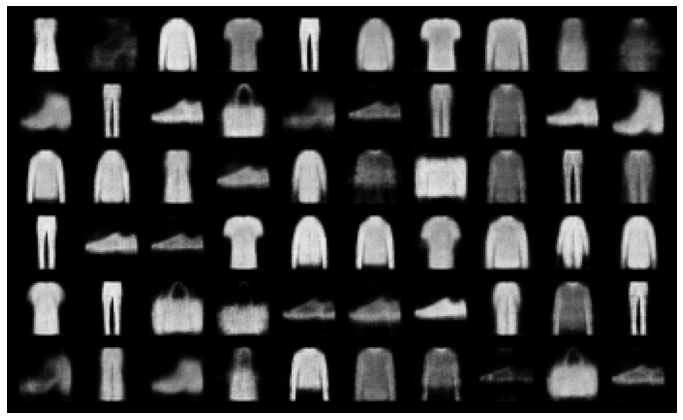

In [ ]:
with torch.no_grad():
    # TODO
    samples = model.sample(mu,logvar) 
    new_images = model.decode(samples)

    #print(samples.shape)
    show_grid(new_images[0:(images_columns * images_rows)], images_columns, images_rows)

### Visualization of image reconstructions

Visualize the image reconstruction process and compare to the original images!

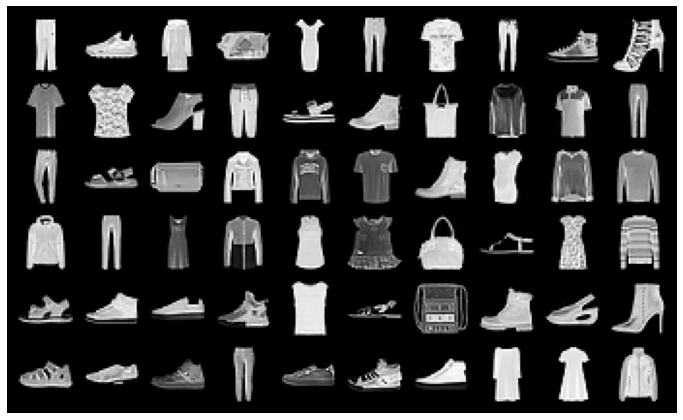

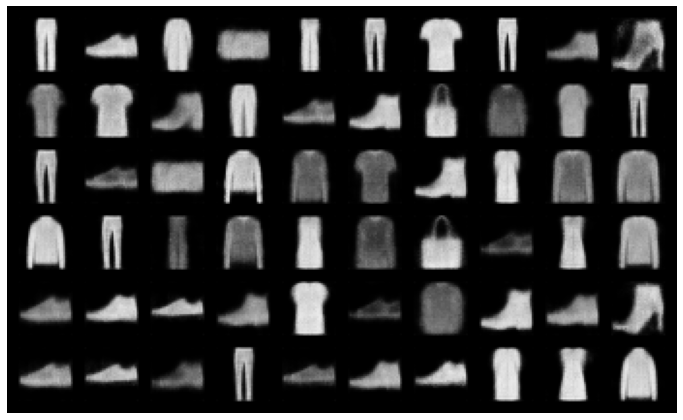

In [ ]:
images_columns = 10
images_rows    = 6

data_iterator = iter(train_loader)
images, labels = data_iterator.next()

# Show original images
show_grid(images[0:(images_columns * images_rows)], images_columns, images_rows)

# Show reconstructed images
model.eval()
with torch.no_grad():

    # TODO: compute reconstruction

    images_recon,mu_test,log_var_test = model(images)

    show_grid(images_recon[0:(images_columns * images_rows)], images_columns, images_rows)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
main_path = '/content/drive/My Drive'

Mounted at /content/drive


In [ ]:
#saving the default model, i.e. with latent_dim=10
import os
model_path = os.path.join(main_path, 'VAE_model.torch')
#torch.save(model.state_dict(), model_path)


In [ ]:

model_test = VAE()
model_test.load_state_dict(torch.load(model_path))

<All keys matched successfully>

### Optimization

**TASK 3: Explore dimensionality of latent space**

How does the dimensionality of latent space (set to 10 by default in our case) affect loss and quality of the reconstructions? Explore smaller and larger latent dimensionality by using 2, 4, 8, 16, 32 dimensions and looking at reconstructions and resulting test set loss.

In [ ]:
epochs = 5
lr = 0.001
model = VAE(latent_dims=16)
optimizer = torch.optim.Adam(model.parameters(), lr=lr,weight_decay=1e-5)
loss_func = vae_loss

In [ ]:
loss_values_total,loss_values_mse,loss_values_kld, preds, actuals,mu, logvar = train_model(model, train_loader,optimizer,loss_func, epochs)


In [ ]:
print (loss_values_kld)

[tensor(7.7421, grad_fn=<MeanBackward1>), tensor(7.8261, grad_fn=<MeanBackward1>), tensor(7.9182, grad_fn=<MeanBackward1>), tensor(7.8305, grad_fn=<MeanBackward1>), tensor(7.4797, grad_fn=<MeanBackward1>), tensor(7.6993, grad_fn=<MeanBackward1>), tensor(7.3627, grad_fn=<MeanBackward1>), tensor(7.0616, grad_fn=<MeanBackward1>), tensor(7.3674, grad_fn=<MeanBackward1>), tensor(7.2066, grad_fn=<MeanBackward1>), tensor(6.7044, grad_fn=<MeanBackward1>), tensor(7.1112, grad_fn=<MeanBackward1>), tensor(6.8086, grad_fn=<MeanBackward1>), tensor(7.1971, grad_fn=<MeanBackward1>), tensor(6.8528, grad_fn=<MeanBackward1>), tensor(7.1091, grad_fn=<MeanBackward1>), tensor(7.2342, grad_fn=<MeanBackward1>), tensor(7.0520, grad_fn=<MeanBackward1>), tensor(7.2159, grad_fn=<MeanBackward1>), tensor(8.2383, grad_fn=<MeanBackward1>), tensor(7.5291, grad_fn=<MeanBackward1>), tensor(7.8348, grad_fn=<MeanBackward1>), tensor(8.1655, grad_fn=<MeanBackward1>), tensor(8.0370, grad_fn=<MeanBackward1>), tensor(7.9604, 

In [ ]:
print (loss_values_mse)

[tensor(18.9213, grad_fn=<DivBackward0>), tensor(21.8013, grad_fn=<DivBackward0>), tensor(21.8745, grad_fn=<DivBackward0>), tensor(20.2003, grad_fn=<DivBackward0>), tensor(17.4190, grad_fn=<DivBackward0>), tensor(19.8498, grad_fn=<DivBackward0>), tensor(21.0341, grad_fn=<DivBackward0>), tensor(22.8073, grad_fn=<DivBackward0>), tensor(20.6677, grad_fn=<DivBackward0>), tensor(18.2653, grad_fn=<DivBackward0>), tensor(15.9943, grad_fn=<DivBackward0>), tensor(23.8381, grad_fn=<DivBackward0>), tensor(19.6066, grad_fn=<DivBackward0>), tensor(20.3187, grad_fn=<DivBackward0>), tensor(22.8446, grad_fn=<DivBackward0>), tensor(27.2473, grad_fn=<DivBackward0>), tensor(21.6369, grad_fn=<DivBackward0>), tensor(18.9716, grad_fn=<DivBackward0>), tensor(28.5737, grad_fn=<DivBackward0>), tensor(22.1037, grad_fn=<DivBackward0>), tensor(21.1623, grad_fn=<DivBackward0>), tensor(19.5610, grad_fn=<DivBackward0>), tensor(25.9573, grad_fn=<DivBackward0>), tensor(20.8054, grad_fn=<DivBackward0>), tensor(19.0610,

In [ ]:
epochs = 5
lr = 0.001
model = VAE(latent_dims=32)
optimizer = torch.optim.Adam(model.parameters(), lr=lr,weight_decay=1e-5)
loss_func = vae_loss

In [ ]:
loss_values_total,loss_values_mse,loss_values_kld, preds, actuals,mu, logvar = train_model(model, train_loader,optimizer,loss_func, epochs)


In [ ]:
print (loss_values_mse)

[tensor(18.3552, grad_fn=<DivBackward0>), tensor(21.5624, grad_fn=<DivBackward0>), tensor(20.8066, grad_fn=<DivBackward0>), tensor(20.7634, grad_fn=<DivBackward0>), tensor(20.7130, grad_fn=<DivBackward0>), tensor(24.4520, grad_fn=<DivBackward0>), tensor(20.1005, grad_fn=<DivBackward0>), tensor(19.3792, grad_fn=<DivBackward0>), tensor(26.1267, grad_fn=<DivBackward0>), tensor(19.9703, grad_fn=<DivBackward0>), tensor(27.2719, grad_fn=<DivBackward0>), tensor(27.1238, grad_fn=<DivBackward0>), tensor(27.3173, grad_fn=<DivBackward0>), tensor(20.7429, grad_fn=<DivBackward0>), tensor(18.8324, grad_fn=<DivBackward0>), tensor(21.3071, grad_fn=<DivBackward0>), tensor(26.5520, grad_fn=<DivBackward0>), tensor(25.1011, grad_fn=<DivBackward0>), tensor(30.4266, grad_fn=<DivBackward0>), tensor(23.2336, grad_fn=<DivBackward0>), tensor(22.5998, grad_fn=<DivBackward0>), tensor(20.9264, grad_fn=<DivBackward0>), tensor(22.4372, grad_fn=<DivBackward0>), tensor(22.1905, grad_fn=<DivBackward0>), tensor(19.8888,

In [ ]:
print (loss_values_kld)

[tensor(8.6784, grad_fn=<MeanBackward1>), tensor(8.4086, grad_fn=<MeanBackward1>), tensor(8.4325, grad_fn=<MeanBackward1>), tensor(8.4578, grad_fn=<MeanBackward1>), tensor(7.8786, grad_fn=<MeanBackward1>), tensor(7.8977, grad_fn=<MeanBackward1>), tensor(7.7285, grad_fn=<MeanBackward1>), tensor(7.3840, grad_fn=<MeanBackward1>), tensor(6.9391, grad_fn=<MeanBackward1>), tensor(7.4681, grad_fn=<MeanBackward1>), tensor(7.0436, grad_fn=<MeanBackward1>), tensor(7.1915, grad_fn=<MeanBackward1>), tensor(7.6475, grad_fn=<MeanBackward1>), tensor(7.4345, grad_fn=<MeanBackward1>), tensor(7.6339, grad_fn=<MeanBackward1>), tensor(7.9690, grad_fn=<MeanBackward1>), tensor(8.3491, grad_fn=<MeanBackward1>), tensor(8.0080, grad_fn=<MeanBackward1>), tensor(8.2159, grad_fn=<MeanBackward1>), tensor(8.6576, grad_fn=<MeanBackward1>), tensor(8.2525, grad_fn=<MeanBackward1>), tensor(8.7317, grad_fn=<MeanBackward1>), tensor(8.9325, grad_fn=<MeanBackward1>), tensor(8.3292, grad_fn=<MeanBackward1>), tensor(9.0458, 

## Visualization of latent traversals

**TASK 4: Plot some latent traversals**

Latent traversal is a popular approach to visualize the disentangled latent representations. Given a bunch of variations in a single unit of the latent representation, it is expected that there is a change in a single factor of variation of the data while others are fixed. 
[https://www.ecva.net/papers/eccv_2020/papers_ECCV/papers/123550681.pdf]

Create a 10 x 10 matrix plot showing latent space travels by selecting vectors from latent space and using the decoder part of the VAE neural network to create images from them. 



An example is shown here: 

![10x10 traversal of two latent dimensions](https://i.imgur.com/hZXIYzv.png)


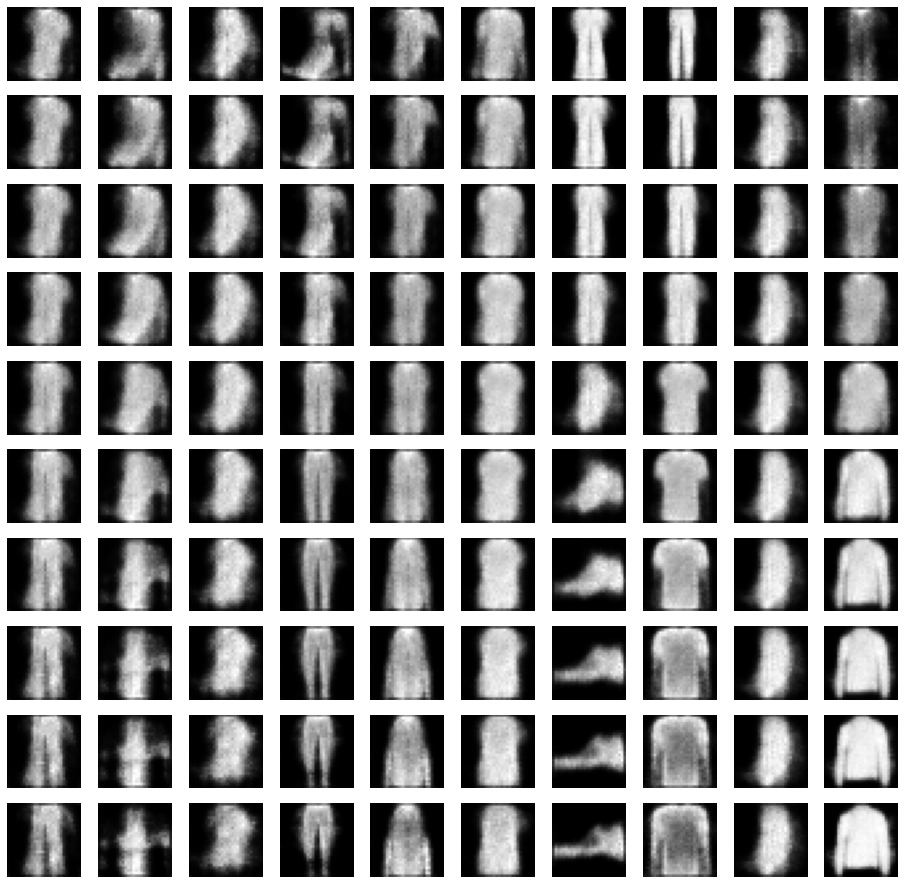

In [ ]:
#print (mu_test.shape)
images_columns=10
images_rows=10
begin_range= -3
end_range = 3
steps=10
fig_w = 16
fig_h = 16

traversal = (end_range - begin_range)/steps
recon_images = []
fig,ax = plt.subplots(nrows=10,ncols=10)


for i in range(0,10):
  random_mu = torch.rand((1,10))
  axes= [i]
  begin_range= 3 #begin_ranges[i]
  end_range = -3 #-begin_ranges[i]
  traversal = (end_range - begin_range)/steps


  for j in range(10):
    random_mu[:,axes]= begin_range+traversal

    #print (mu_test[:,[0,9]])
    new_encoder = random_mu
    new_sample = model.sample(new_encoder,log_var_test)
    recon_image = model.decode(new_sample)

    begin_range = begin_range + traversal
    #print ('recon_image shape',(recon_image.detach().numpy().shape))
    #recon_images.append((recon_image.detach().numpy()))
    #print (recon_image.shape)

    fig = plt.gcf()
    fig.set_size_inches(fig_w, fig_h)
    ax[j,i].imshow(recon_image[0].detach().numpy()[0],cmap='gray')
    ax[j,i].axis('off')


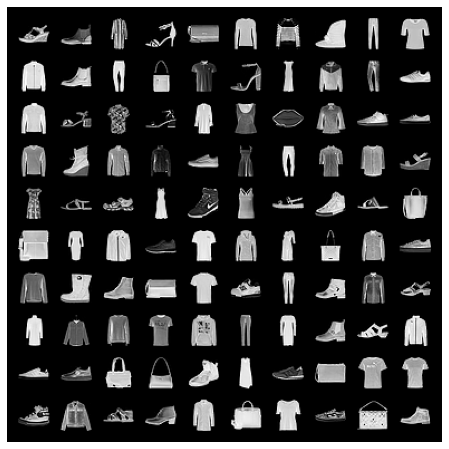

torch.Size([128, 10])
torch.Size([128, 1, 28, 28])
torch.Size([128, 10])
torch.Size([128, 1, 28, 28])
torch.Size([128, 10])
torch.Size([128, 1, 28, 28])
torch.Size([128, 10])
torch.Size([128, 1, 28, 28])
torch.Size([128, 10])
torch.Size([128, 1, 28, 28])
torch.Size([128, 10])
torch.Size([128, 1, 28, 28])
torch.Size([128, 10])
torch.Size([128, 1, 28, 28])
torch.Size([128, 10])
torch.Size([128, 1, 28, 28])
torch.Size([128, 10])
torch.Size([128, 1, 28, 28])
torch.Size([128, 10])
torch.Size([128, 1, 28, 28])


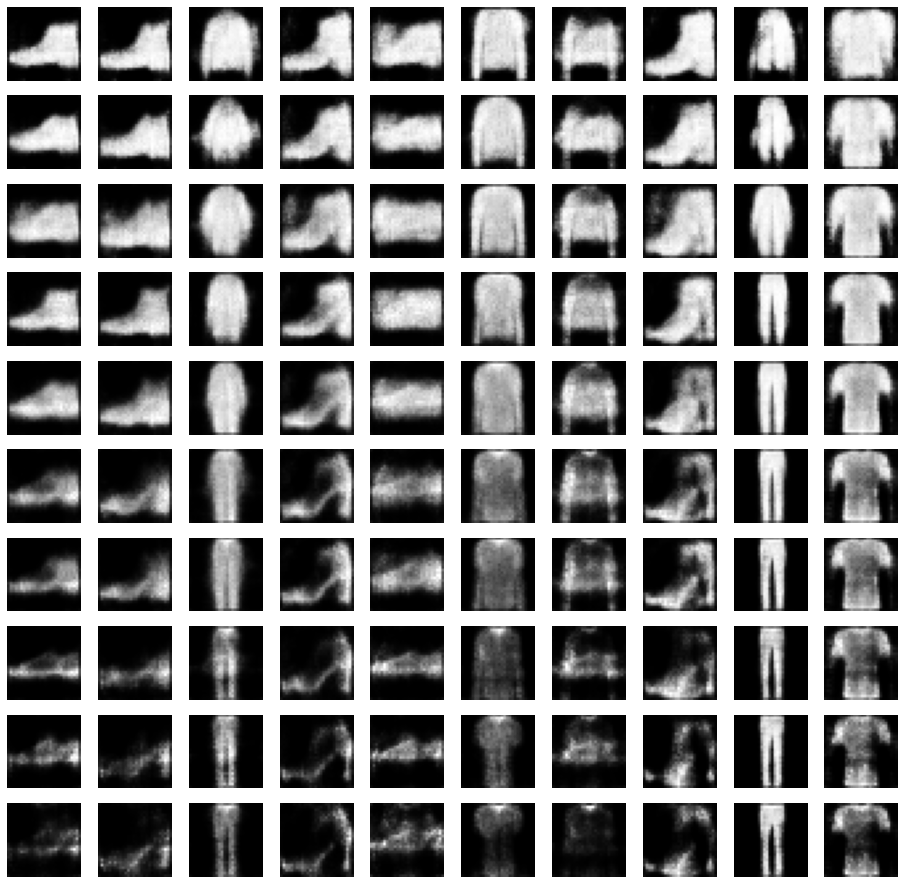

In [ ]:
# latent traversal by keeping latent dim of original images,  just to explore
#print (mu_test.shape)

#first reconstruct using the model again

data_iterator = iter(train_loader)
images, labels = data_iterator.next()

# Show original images
show_grid(images[0:(images_columns * images_rows)], images_columns, images_rows)

# Show reconstructed images
model.eval()
with torch.no_grad():

    # TODO: compute reconstruction

    images_recon,mu_recon,log_var_recon = model(images)






images_columns=10
images_rows=10
begin_range= -3
end_range = 3
steps=10
fig_w = 16
fig_h = 16

traversal = (end_range - begin_range)/steps
recon_images = []
fig,ax = plt.subplots(nrows=10,ncols=10)
for i in range(10):
  mu_recon[:,[0,9]]= begin_range+traversal

  #print (mu_test[:,[0,9]])
  new_encoder =  mu_recon
  new_sample = model_test.sample(new_encoder,log_var_test)
  recon_image = model_test.decode(new_sample)

  begin_range = begin_range + traversal
  #print ('recon_image shape',(recon_image.detach().numpy().shape))
  recon_images.append((recon_image.detach().numpy()))
  print (recon_image.shape)

  #plt.figure(i)
  #plt.imshow(recon_image[0].detach().numpy()[0], cmap='gray')

image_tensor=torch.squeeze(torch.tensor(np.array(recon_images)))
#print ('shape of image tensor',image_tensor.shape)
#image= torchvision.utils.make_grid(image_tensor[:,0:10,:,:], images_columns, images_rows)
#image = torchvision.utils.make_grid(images_tensor, images_columns, images_rows)
    #image = image.numpy()


for i in range(0,10):
 for j in range(0,10):

  fig = plt.gcf()
  fig.set_size_inches(fig_w, fig_h)
  #plt.imshow(np.transpose(image, (1, 2, 0)))
  ax[i,j].imshow(image_tensor[i,j,:,:],cmap='gray')
  ax[i,j].axis('off')
  #plt.show()


#show_grid(new_images[0:(images_columns * images_rows)], images_columns, images_rows)

### Visualize class labels in latent space

**TASK 5: Visualize class labels in latent space**

First create a new VAE-model with a 2d latent space on the full training data set. Then project all the images of the training set into the 2d latent space keeping track of their class labels. Use a 2d scatter plot to visualize the resulting latent space vectors and different colors for their labels. 

- Do images of the same class cluster in latent space?
- Do the data points in latent space look like a normal distribution?

#### Train 2d latent space model

In [ ]:
# TODO

model_2d = VAE(latent_dims=2)

epochs = 5
lr = 0.001
optimizer = torch.optim.Adam(model_2d.parameters(), lr=lr,weight_decay=1e-5)# TODO
loss_func = vae_loss

In [ ]:
loss_values_total,loss_values_mse,loss_values_kld, preds, actuals,mu, logvar = train_model(model_2d, train_loader,optimizer,loss_func, epochs)


In [ ]:
print (loss_values_kld)

[tensor(3.9941, grad_fn=<MeanBackward1>), tensor(4.0195, grad_fn=<MeanBackward1>), tensor(4.0130, grad_fn=<MeanBackward1>), tensor(4.1682, grad_fn=<MeanBackward1>), tensor(4.3017, grad_fn=<MeanBackward1>), tensor(4.3295, grad_fn=<MeanBackward1>), tensor(4.1124, grad_fn=<MeanBackward1>), tensor(4.3466, grad_fn=<MeanBackward1>), tensor(4.3632, grad_fn=<MeanBackward1>), tensor(4.0961, grad_fn=<MeanBackward1>), tensor(4.0884, grad_fn=<MeanBackward1>), tensor(4.0128, grad_fn=<MeanBackward1>), tensor(4.1677, grad_fn=<MeanBackward1>), tensor(4.0860, grad_fn=<MeanBackward1>), tensor(4.2114, grad_fn=<MeanBackward1>), tensor(4.0814, grad_fn=<MeanBackward1>), tensor(4.2418, grad_fn=<MeanBackward1>), tensor(4.3526, grad_fn=<MeanBackward1>), tensor(4.4106, grad_fn=<MeanBackward1>), tensor(4.4148, grad_fn=<MeanBackward1>), tensor(4.4358, grad_fn=<MeanBackward1>), tensor(4.5378, grad_fn=<MeanBackward1>), tensor(4.6157, grad_fn=<MeanBackward1>), tensor(4.7053, grad_fn=<MeanBackward1>), tensor(4.6574, 

In [ ]:
import os
model_file = os.path.join(main_path, 'VAE2D_model.torch')
#torch.save(model_2d.state_dict(), model_file)

In [ ]:
VAE_2d_test = VAE(latent_dims=2)

VAE_2d_test.load_state_dict(torch.load(model_file))

<All keys matched successfully>

#### Visualize classes

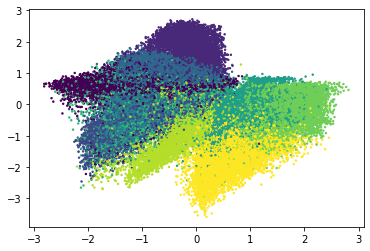

In [ ]:



VAE_2d_test.eval()
with torch.no_grad():

    # TODO: compute reconstruction

    for x,y in train_loader:

      labels = y
      images_2d,mu_2d,log_var_2d = VAE_2d_test(x)
      detached_mu = mu_2d.detach().numpy()
      plt.scatter(detached_mu[:,0],detached_mu[:,1],c=labels,s=2)







## Appendix [OPTIONAL]

Use standard MNIST or CIFAR-10 instead of fashion MNIST.

In [ ]:
transform = transforms.Compose([ 
#                transforms.Resize(image_size),
                transforms.ToTensor(),
#                transforms.Normalize((0.1307,), (0.3081,))
            ])

train_dataset = datasets.MNIST(data_dir, train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(data_dir, train=False, transform=transforms.ToTensor())

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw





Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!
